This colab implements logistic regression for recognizing hand-written digits. For this task, we will be using MNIST training dataset.
 We will be solving two problems:
# Binary classification problem to detect if the image contains digit 5 (label 1) or not (label 0).
# Multiclass classification problem to detect all 10 handwritten digits.

MNIST dataset can be downloaded with sklearn.datasets.fetch_openml API.
openml.org is a public repository for machine learning data and experiments, that allows everybody to upload open datasets.

In [1]:
from sklearn.datasets import fetch_openml

We can read documentation of `fetch_openml` by simply executing the following command:


In [2]:
?fetch_openml


We can load the dataset by specifying the dataset id.  For MNIST dataset, the id is `minist_784`. 

In [3]:
images, labels = fetch_openml('mnist_784',version=1,return_X_y=True)

# convert to numpy array
image_array = images.to_numpy()
label_array = labels.to_numpy()

Now divide the dataset into training and test.  Let's use
first 60,000 examples as training and the rest as test examples.

In [6]:
images_train, images_test, label_train, label_test = (image_array[:60000],image_array[60000:],label_array[:60000],label_array[60000:])
import numpy as np

np.unique(label_train)


array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

Let's make training data for the first task, which is detecting 5 from the image of a digit.

In [7]:
train_label_5 = np.zeros((len(label_train)))
test_label_5 = np.zeros((len(label_test)))

train_index_label_5 = np.where(label_train =='5')
train_label_5[train_index_label_5] = 1

test_index_label_5 = np.where(label_test == '5')
test_label_5[test_index_label_5] = 1

Now we have dataset for the 5-detector task.


*   Print the shapes of training data - images and labels.




In [8]:
images_train.shape

(60000, 784)

In [9]:
len(train_label_5)

60000

In [10]:
assert images_train.shape[0] == len(train_label_5)

In [11]:
assert images_test.shape[0] == len(test_label_5)

# 5-detector Model
We can build the logistic regression model in sklearn with the following three APIs:
*   `sklearn.linear_model.SGDClassifier`
*   `sklearn.linear_model.LogisticRegression`
*   `sklearn.linear_model.RidgeClassifier`

For this project, we will use sklearn.linear_model.LogisticRegression API for building the model.

Before building any serious model, it's a good idea to build a baseline mode. We have `sklearn.dummy.DummyClassifier` available for that task - here we assign the most frequently appearing label in the training set to the new image through most_frequent strategy argument.

In [12]:
from sklearn.dummy import DummyClassifier

baseline_model = DummyClassifier(strategy='most_frequent') 
baseline_model.fit(images_train, train_label_5)
print(baseline_model.score(images_train, train_label_5))

0.90965


Note that the baseline accuracy is 90%.

In [13]:
from sklearn.linear_model import LogisticRegression
?LogisticRegression

We will use `MinMaxScalar` for scaling the dataset.  We can't use z-score normalization here, as we do not want to alter 0 values in the images

In [14]:
logreg_model = LogisticRegression(
    random_state=1729, C=np.infty)

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

It's a good idea to put all operations in a pipeline so that they get applied consistently across training and inference times.

In [16]:
from sklearn.pipeline import Pipeline

pipe_logit = Pipeline(steps=[("scaler", scaler),
                             ("logreg", logreg_model)])

Now comes the training part:

In [17]:
pipe_logit.fit(images_train, train_label_5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logreg', LogisticRegression(C=inf, random_state=1729))])

In [18]:
pipe_logit[-1].classes_
# Classes

array([0., 1.])

In [19]:
pipe_logit[-1].coef_
# Weights

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.63743024e-03, -1.66601307e-03, -3.74029419e-05,
        -3.74029419e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -5.15928137e-05,
        -5.57720865e-05, -1.53364950e-03, -1.70209467e-03,
        -3.66416139e-03, -1.20123914e-02, -5.60537318e-02,
        -5.25750587e-02, -7.57172806e-02, -7.49487921e-02,
        -3.98764304e-02, -5.38785393e-02, -4.99516931e-02,
        -2.34195943e-02, -3.63758373e-02, -3.78128520e-02,
        -2.32480832e-02, -4.95076213e-03, -8.14668180e-0

In [20]:
pipe_logit[-1].intercept_
#intercept

array([0.31715902])

## Prediction and model evaluation



In [21]:
test_predictions = pipe_logit.predict(images_test)

Let's print confusion matrix with `ConfusionMatrixDisplay` utility in `sklearn.metrics`

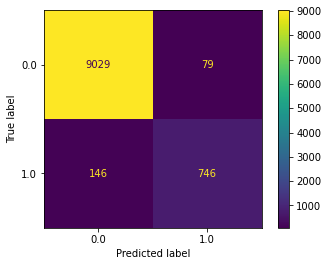

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_display = ConfusionMatrixDisplay.from_predictions(test_label_5,
                                                     test_predictions,
                                                     values_format='.5g') 
# it return matplotlin plot object
plt.show()

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_lr = precision_score(test_label_5, test_predictions)
recall_lr = recall_score(test_label_5, test_predictions)

from sklearn.metrics import precision_recall_curve

prediction_scores = pipe_logit.decision_function(images_test)
precisions, recalls, thresholds = precision_recall_curve(
    test_label_5, prediction_scores)


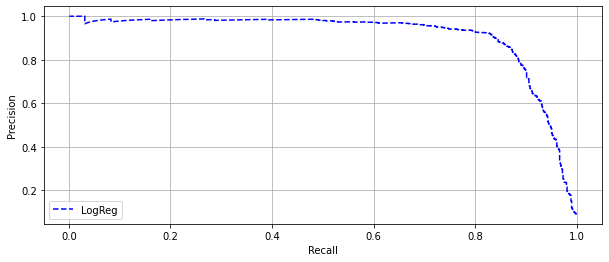

In [25]:
plt.figure(figsize=(10,4))
plt.plot(recalls[:-1], precisions[:-1], 'b--', label='LogReg')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

In [26]:
from sklearn.metrics import auc
auc = auc(recalls[:-1], precisions[:-1])
auc

0.9108576536514077

Let's try to tune parameter `C` (Hyper Prameteric Tuning):

In [28]:
from sklearn.model_selection import GridSearchCV

grid_Cs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

scaler = MinMaxScaler()
logreg = LogisticRegression(C=1.0, random_state=1729)

pipe = Pipeline(steps=[("scaler", scaler), 
                       ("logistic", logreg)])

pipe_logit_cv = GridSearchCV(
    pipe,
    param_grid={"logistic__C": grid_Cs},
    scoring='f1')
pipe_logit_cv.fit(images_train, train_label_5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

The `GridSearchCV` finds the best value of `C` and refits the estimator by default on the entire training set.  This gives us the logistic regression classifier with best value of `C`.

We can check the value of the best parameter by accessing the `best_params_` 
member variable of the `GridSearchCV` object.


In [29]:
pipe_logit_cv.best_params_

{'logistic__C': 10.0}

In [30]:
pipe_logit_cv.best_score_

0.8553629503031228

In [31]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=10.0, random_state=1729))])

## Model evaluation

In [32]:
test_predictions_cv = pipe_logit_cv.best_estimator_.predict(images_test)

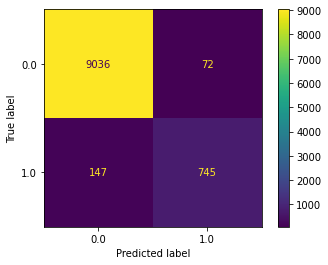

In [33]:
cm_display = ConfusionMatrixDisplay.from_predictions(test_label_5,
                                                     test_predictions_cv,
                                                     values_format='.5g') 
plt.show()

So as we can see from the confusion matrix, there are 745 5's truly identified, and 9036 non 5's truly identified.

## Multi-class classification

In [34]:
pipe_logit_ovr = pipe = Pipeline(
    steps=[("scaler", scaler), 
           ("logistic", LogisticRegression(random_state=1729,
                                                  solver='lbfgs',
                                                  C=np.infty))])
pipe_logit_ovr.fit(images_train, label_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=inf, random_state=1729))])

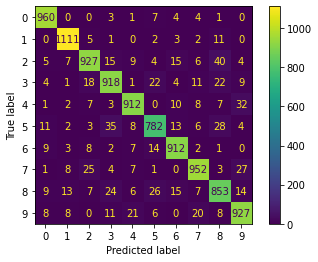

In [35]:
predicted_labels = pipe_logit_ovr.predict(images_test)
cm_display = ConfusionMatrixDisplay.from_predictions(label_test, predicted_labels,
                                                     values_format='.5g')
plt.show()

In [36]:
from sklearn.metrics import classification_report

print(classification_report(label_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



# Theory

### Loss function
\begin{equation}
\operatorname{Loss}=-\frac{1}{\substack{\text { output } \\ \text { size }}} \sum_{i=1}^{\substack{\text { output } \\ \text { size }}} y_{i} \cdot \log \hat{y}_{i}+\left(1-y_{i}\right) \cdot \log \left(1-\hat{y}_{i}\right)
\end{equation}

Here yi is Actual value and y*i is Predicted value